In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torch.optim as optim
import torch.nn as nn
#from base.constants import *
#from ..base.helpers import *
from tqdm import tqdm
from transformers import pipeline, file_utils
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
import json

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


## Data preparation

Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_texts_path = '/content/drive/My Drive/data/train_without_labels.txt'
train_labels_path = '/content/drive/My Drive/data/train_with_labels.txt'
val_texts_path = '/content/drive/My Drive/data/val_without_labels.txt'
val_labels_path = '/content/drive/My Drive/data/val_with_labels.txt'

In [5]:
# Load datasets
train_texts = []
with open(train_texts_path, 'r', encoding='utf-8') as file:
    for line in file:
        train_texts.append(line.strip())

train_texts_with_labels = []
with open(train_labels_path, 'r', encoding='utf-8') as file:
    for line in file:
        train_texts_with_labels.append(line.strip())

val_texts = []
with open(val_texts_path, 'r', encoding='utf-8') as file:
    for line in file:
        val_texts.append(line.strip())

val_texts_with_labels = []
with open(val_labels_path, 'r', encoding='utf-8') as file:
    for line in file:
        val_texts_with_labels.append(line.strip())

Have a knowledge of the tokenizer

In [6]:
CACHE_DIR = os.environ.get("TRANSFORMERS_CACHE")

try:
    tokenizer = AutoTokenizer.from_pretrained("igorsterner/xlmr-multilingual-sentence-segmentation",
                                              cache_dir=CACHE_DIR)

except Exception as e:
    print("You need to pick a pre-trained model from HuggingFace.")
    print("Exception: ", e)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Print the original sentence.
print(' Original: ', train_texts[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_texts[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_texts[0])))

# Print special marks and their IDs.
print("CLS token:", tokenizer.cls_token, tokenizer.cls_token_id)
print("SEP token:", tokenizer.sep_token, tokenizer.sep_token_id)

 Original:  Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
Tokenized:  ['▁Thank', '▁you', '▁so', '▁much', ',', '▁Chris', '.', '▁And', '▁it', "'", 's', '▁truly', '▁a', '▁great', '▁honor', '▁to', '▁have', '▁the', '▁opportunity', '▁to', '▁come', '▁to', '▁this', '▁stage', '▁twice', ';', '▁I', "'", 'm', '▁extremely', '▁grateful', '.']
Token IDs:  [25689, 398, 221, 5045, 4, 31745, 5, 3493, 442, 25, 7, 87607, 10, 6782, 20338, 47, 765, 70, 54591, 47, 1380, 47, 903, 36541, 186351, 74, 87, 25, 39, 111531, 225876, 5]
CLS token: <s> 0
SEP token: </s> 2


Preprocess data

In [8]:
# Define functions to convert texts with <eol> and <eob> tags to output format
def mark_breakpoints(input_ids):
    # Initialize a list of zeros for marks, same length as input_ids
    marks = [0] * len(input_ids)

    i = 0
    while i < len(input_ids):
        # tokenizer("") == {'input_ids': [0, 2], 'attention_mask': [1, 1]}
        # tokenizer("<eob>") == {'input_ids': [0, 4426, 13, 3522, 2740, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}
        # tokenizer("<eol>") == {'input_ids': [0, 4426, 13, 929, 2740, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}
        # Check for the patterns corresponding to <eob> or <eol>
        if input_ids[i:i+4] == [4426, 13, 3522, 2740] or input_ids[i:i+4] == [4426, 13, 929, 2740]:
            # Determine the marker value, 2 for <eob> and 1 for <eol>
            mark_value = 2 if input_ids[i+2] == 3522 else 1
            if i > 0:  # Ensure it is not at the start of the sequence
                marks[i-1] = mark_value  # Mark the previous token
            # Remove the tokens associated with <eob> or <eol>
            del marks[i:i+4]
            del input_ids[i:i+4]
        else:
            i += 1

    return marks

def texts2labels(texts_with_labels):
    labels = []
    for i in texts_with_labels:
        label = mark_breakpoints(tokenizer(i)['input_ids'])
        labels.append(label)
    return labels


In [9]:
train_labels = texts2labels(train_texts_with_labels)
val_labels = texts2labels(val_texts_with_labels)

In [10]:
max_len = 0

# For every sentence...
for sent in train_texts:
    input_ids = tokenizer(sent)['input_ids']
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  300


In [11]:
def prepare_inputs_outputs(texts, labels, max_length=330, print_samples = False):
    input_ids = []
    attention_masks = []
    padded_labels = []

    # For every sentence...
    for sent in texts:
        encoded_dict = tokenizer(
                            sent,                          # Sentence to encode.
                            max_length = max_length,       # Pad & truncate all sentences.
                            padding='max_length',
                            return_attention_mask = True,  # Construct attn. masks.
                            return_tensors = 'pt',         # Return pytorch tensors.
                    )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Pad labels
    padded_labels = torch.tensor([label + [-1] * (max_length - len(label)) for label in labels])

    # print samples
    if print_samples == True:
        print('Original: ', texts[0])
        print('Token IDs:', input_ids[0])
        print('Attention Masks:', attention_masks[0])
        print('labels', padded_labels[0])

    return input_ids, attention_masks, padded_labels


In [12]:
train_input_ids, train_attention_masks, train_padded_labels = prepare_inputs_outputs(train_texts, train_labels, 330, True)
val_input_ids, val_attention_masks, val_padded_labels = prepare_inputs_outputs(val_texts, val_labels, 330)

Original:  Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
Token IDs: tensor([     0,  25689,    398,    221,   5045,      4,  31745,      5,   3493,
           442,     25,      7,  87607,     10,   6782,  20338,     47,    765,
            70,  54591,     47,   1380,     47,    903,  36541, 186351,     74,
            87,     25,     39, 111531, 225876,      5,      2,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1

Create PyTorch Datasets and DataLoaders

In [13]:
class SubtitleDataset(Dataset):
    def __init__(self, input_ids, attention_masks, padded_labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.padded_labels = padded_labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        """ input_id = torch.tensor(self.input_ids[idx], dtype=torch.long)
        attention_mask = torch.tensor(self.attention_masks[idx], dtype=torch.long)
        padded_label = torch.tensor(self.padded_labels[idx], dtype=torch.long) """

        return self.input_ids[idx], self.attention_masks[idx], self.padded_labels[idx]

In [14]:
train_dataset = SubtitleDataset(train_input_ids, train_attention_masks, train_padded_labels)
val_dataset = SubtitleDataset(val_input_ids, val_attention_masks, val_padded_labels)

#train_dataset = Subset(train_dataset, range(1000))
#val_dataset = Subset(val_dataset, range(50))

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_mask, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size())# batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample mask: \n', sample_mask)
print('Sample output: \n', sample_y)

220,068 training samples
27,509 validation samples
Sample input size:  torch.Size([16, 330])
Sample input: 
 tensor([[    0, 14240,    87,  ...,     1,     1,     1],
        [    0,  3493,   221,  ...,     1,     1,     1],
        [    0, 14240,     4,  ...,     1,     1,     1],
        ...,
        [    0,   360, 66044,  ...,     1,     1,     1],
        [    0, 32255, 17311,  ...,     1,     1,     1],
        [    0,  1401, 68872,  ...,     1,     1,     1]])
Sample mask: 
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Sample output: 
 tensor([[ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        ...,
        [ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1]])


## Model Selection

In [15]:
model = AutoModelForTokenClassification.from_pretrained("igorsterner/xlmr-multilingual-sentence-segmentation")
model.classifier = torch.nn.Linear(model.classifier.in_features, 3)
model.num_labels = 3

model.to(device)
model.cuda()

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

In [16]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=2e-5,
                              betas=(0.9, 0.999),
                              eps = 1e-8,
                              weight_decay=0.0001,
                              )

epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [17]:
weights = torch.tensor([1.0, 2.5, 2]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=-1)

# Training

In [18]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
torch.cuda.empty_cache()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
accumulation_steps = 2

training_stats = []

total_t0 = time.time()


for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_loader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        loss = criterion(logits.view(-1, 3), b_labels.to(device).view(-1))
        loss = loss / accumulation_steps  # Scale loss
        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            # Only perform optimization step every 'accumulation_steps'
            torch.nn.utils.clip_grad_norm_(model.parameters(), 4.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()
            model.zero_grad()  # Zero the gradients after optimization

        total_train_loss += loss.item() * accumulation_steps  # Unscale the loss
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_loader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_loader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            result = model(b_input_ids,
                           attention_mask=b_input_mask,
                           return_dict=True)

        logits = result.logits
        loss = criterion(logits.view(-1, 3), b_labels.to(device).view(-1))

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    #avg_val_accuracy = total_eval_accuracy / len(val_loader)
    #print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_loader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            #'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  13,755.    Elapsed: 0:00:21.
  Batch    80  of  13,755.    Elapsed: 0:00:41.
  Batch   120  of  13,755.    Elapsed: 0:01:01.
  Batch   160  of  13,755.    Elapsed: 0:01:22.
  Batch   200  of  13,755.    Elapsed: 0:01:42.
  Batch   240  of  13,755.    Elapsed: 0:02:03.
  Batch   280  of  13,755.    Elapsed: 0:02:24.
  Batch   320  of  13,755.    Elapsed: 0:02:44.
  Batch   360  of  13,755.    Elapsed: 0:03:05.
  Batch   400  of  13,755.    Elapsed: 0:03:25.
  Batch   440  of  13,755.    Elapsed: 0:03:46.
  Batch   480  of  13,755.    Elapsed: 0:04:07.
  Batch   520  of  13,755.    Elapsed: 0:04:27.
  Batch   560  of  13,755.    Elapsed: 0:04:48.
  Batch   600  of  13,755.    Elapsed: 0:05:09.
  Batch   640  of  13,755.    Elapsed: 0:05:29.
  Batch   680  of  13,755.    Elapsed: 0:05:50.
  Batch   720  of  13,755.    Elapsed: 0:06:11.
  Batch   760  of  13,755.    Elapsed: 0:06:31.
  Batch   800  of  13,755.    Elapsed: 0:06:5

Let's view the summary of the training process.

In [31]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.22,0.17,1:58:18,0:04:18
2,0.20,0.17,1:58:18,0:04:18
3,0.19,0.17,1:58:18,0:04:18
4,0.18,0.17,1:58:20,0:04:18


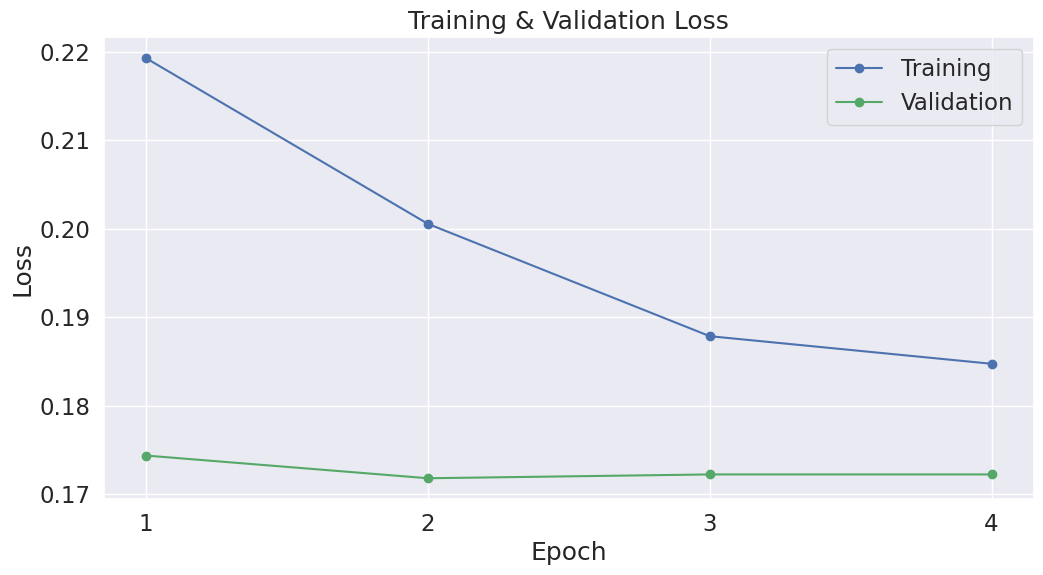

In [28]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Save the model (2 paths)

In [32]:
# Save fine_tuned model
model_save_path = '/content/drive/My Drive/best_model'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

model_path = os.path.join(model_save_path, 'state_dict.pt')
torch.save(model.state_dict(), model_path)

In [30]:
# Save fine_tuned model
if not os.path.exists('best_model'):
  os.makedirs('best_model')
  torch.save(model.state_dict(), 'best_model/state_dict.pt')